In [ ]:
%pip install transformers torch

In [ ]:
%pip install python-dotenv

In [ ]:
%pip install xlsxwriter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 4.1 MB/s eta 0:00:00


In [ ]:
!pip install -q openpyxl

In [ ]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

In [1]:
import pandas as pd
import os
import sys
from transformers import pipeline
import pandas as pd
import os
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
import torch
import os
import sys
import datetime
from tqdm.auto import tqdm

In [2]:
import os, json, re, textwrap, math, datetime, gc
import torch
import pandas as pd
from tqdm.auto import tqdm

import random, numpy as np
torch.manual_seed(0); random.seed(0); np.random.seed(0)
torch.use_deterministic_algorithms(True)

In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


In [3]:
if 'google.colab' in sys.modules:
  from google.colab import drive
  drive.mount('/content/drive')
  path_prefix = '/content/drive/MyDrive/Great Learning/DBA/Walsh-MS-QM640CapstoneProject/'
  print("Running in Google Colab.")
else:
  path_prefix = './'
  print("Not running in Google Colab.")

print(f"Using path prefix: {path_prefix}")

Not running in Google Colab.
Using path prefix: ./


In [ ]:
df_reviews = pd.read_excel(f"{path_prefix}scored/reviews_scored.xlsx")
print(df_reviews.shape)
df_reviews.head()

(68879, 29)


,reviewId,userName,reviewContent,rating,reviewedAt,replyContent,repliedAt,store,app_name,language,...,responded_by,scores,Negative,Neutral,Positive,scores_,Negative_,Positive_,Sentiment,Sentiment_
0,a2393404-7755-4564-add7-b3029159bb71,Farhat Taher,the application now for 4 days is not opening ...,1,2025-07-01 02:04:14,Sorry to hear you're having trouble with the a...,2025-07-01 12:49:59,Google Play Store,ADCB,en,...,A.E,[0.71761656 0.51372194 0.50310713],0.717617,0.513722,0.503107,[0.73096216 0.5001226 ],0.730962,0.500123,Negative,Negative_
1,f521326b-0ffb-4620-8995-b04eeee01c8f,Lee Kasim,normal,3,2025-06-30 22:17:54,NaN,NaT,Google Play Store,ADCB,en,...,NaN,[0.5911989 0.59655565 0.5596994 ],0.591199,0.596556,0.559699,[0.50245154 0.7291262 ],0.502452,0.729126,Neutral,Positive_
2,6262b57b-7c21-4f6b-9a6a-b4fa8d60b395,ayasafputri love,good,5,2025-06-30 21:42:32,"Hello, thank you for the encouraging star rati...",2025-07-01 12:49:03,Google Play Store,ADCB,id,...,A.E,[0.56072223 0.5803966 0.6062329 ],0.560722,0.580397,0.606233,[0.50036734 0.7307696 ],0.500367,0.730770,Positive,Positive_
3,1780c47d-38ad-4563-92c3-c381b717171f,Ismail Momin,good thank you,5,2025-06-30 19:14:18,"Hello, thank you for the encouraging star rati...",2025-07-01 12:49:00,Google Play Store,ADCB,en,...,A.E,[0.51536876 0.5394213 0.6857862 ],0.515369,0.539421,0.685786,[0.5002964 0.73082536],0.500296,0.730825,Positive,Positive_
4,5083ac69-2298-45ee-9b96-1912e10dfed6,Abdullah Khalil fareh Almahri,Dear adcb bank i had a trouble on the Applicat...,5,2025-06-30 19:08:16,Sorry to hear you're having trouble with the a...,2025-07-01 12:49:52,Google Play Store,ADCB,en,...,A.E,[0.6811544 0.54453015 0.51557606],0.681154,0.544530,0.515576,[0.7294929 0.5019872],0.729493,0.501987,Negative,Negative_


In [ ]:
df_reviews.columns

Index(['reviewId', 'userName', 'reviewContent', 'rating', 'reviewedAt',
       'replyContent', 'repliedAt', 'store', 'app_name', 'language', 'at_year',
       'at_month', 'country', 'at_calc', 'at_eta_date', 'reply_in',
       'reply_eta', 'sla_status', 'lang_pred', 'responded_by', 'scores',
       'Negative', 'Neutral', 'Positive', 'scores_', 'Negative_', 'Positive_',
       'Sentiment', 'Sentiment_'],
      dtype='object')

In [ ]:
df_reviews['lang_pred'].value_counts()

,count
lang_pred,
en,56088
ar,12791


## Language Detection to Filter English Reviews

In [ ]:
print(f"Language detection Start at {datetime.datetime.now()}")

# Define the path to save the language detection model and tokenizer
lang_detect_model_save_path = f"{path_prefix}xlm-roberta-base-language-detection"

# Check if the model is already downloaded
model_saved = os.path.exists(os.path.join(lang_detect_model_save_path, "config.json"))

if not model_saved:
    print("Language detection model not found locally. Downloading...")
    # Download and load the model (first time will download weights)
    model_name = "papluca/xlm-roberta-base-language-detection"
    lang_detector = pipeline("text-classification", model=model_name)

    # Save the model and tokenizer (pipelines can save directly)
    lang_detector.save_pretrained(lang_detect_model_save_path)
    print(f"Language detection model saved to {lang_detect_model_save_path}")
else:
    print(f"Language detection model found locally at {lang_detect_model_save_path}. Loading...")
    lang_detector = pipeline("text-classification", model=lang_detect_model_save_path)


# Function to predict language using the loaded pipeline
def predict_language_model(text, max_length=512): # Added max_length parameter
    # Handle potential NaN values or empty strings
    if pd.isna(text) or not str(text).strip():
        return None
    try:
        # Convert non-string to string before detection and truncate
        text_str = str(text) if not isinstance(text, str) else text
        truncated_text = text_str[:max_length] # Truncate the text

        # The pipeline returns a list of dictionaries, e.g., [{'label': 'en', 'score': 0.99}]
        result = lang_detector(truncated_text) # Use truncated_text
        return result[0]['label'] # Return the predicted language label
    except Exception as e:
        print(f"Error predicting language for text: {str(text)[:50]}... Error: {e}")
        return None


# Apply language detection using the model to the 'reviewContent' column
# This might take some time for a large dataset
print("Detecting languages using the XLM-RoBERTa model...")
# Pass max_length to the apply function if needed, or handle within the function as done above
df_reviews['detected_language_model'] = df_reviews['reviewContent'].apply(predict_language_model)

print(f"Language detection complete at {datetime.datetime.now()}")

Language detection Start at 2025-08-24 04:13:42.996420
Language detection model found locally at /content/drive/MyDrive/Great Learning/DBA/Walsh-MS-QM640CapstoneProject/xlm-roberta-base-language-detection. Loading...


Device set to use cuda:0


Detecting languages using the XLM-RoBERTa model...


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Language detection complete at 2025-08-24 04:23:14.055360


In [ ]:
df_reviews.columns

Index(['reviewId', 'userName', 'reviewContent', 'rating', 'reviewedAt',
       'replyContent', 'repliedAt', 'store', 'app_name', 'language', 'at_year',
       'at_month', 'country', 'at_calc', 'at_eta_date', 'reply_in',
       'reply_eta', 'sla_status', 'lang_pred', 'responded_by', 'scores',
       'Negative', 'Neutral', 'Positive', 'scores_', 'Negative_', 'Positive_',
       'Sentiment', 'Sentiment_', 'detected_language_model'],
      dtype='object')

In [ ]:
import pandas as pd

# Create a contingency table comparing the three language columns
# We can use a multi-index for the rows to compare language and lang_pred against detected_language_model
contingency_table = pd.crosstab(
    [ df_reviews['lang_pred']],
    df_reviews['detected_language_model'],
    dropna=False # Include combinations with no occurrences
)

print("Contingency Table: language vs lang_pred vs detected_language_model")
display(contingency_table)

Contingency Table: language vs lang_pred vs detected_language_model


detected_language_model,ar,bg,de,el,en,es,fr,hi,it,ja,...,pl,pt,ru,sw,th,tr,ur,vi,zh,NaN
lang_pred,,,,,,,,,,,,,,,,,,,,,
ar,10190,0,0,0,16,0,0,10,1,0,...,0,0,1,0,1,0,2572,0,0,0
en,1,10,20,8,53703,54,52,562,124,6,...,11,69,41,518,4,54,780,4,31,3


In [ ]:
# Filter the DataFrame to include only English reviews based on detected language from the model
df_reviews_english_model = df_reviews[df_reviews['detected_language_model'] == 'en'].copy()

print(f"Original number of reviews: {len(df_reviews)}")
print(f"Number of English reviews based on model detection: {len(df_reviews_english_model)}")

# Display the value counts for the new detected language column
print("\nValue counts for 'detected_language_model':")
display(df_reviews['detected_language_model'].value_counts())

# Now work with df_reviews_english_model for the classification steps
display(df_reviews_english_model.head())

Original number of reviews: 68879
Number of English reviews based on model detection: 53719

Value counts for 'detected_language_model':


,count
detected_language_model,
en,53719
ar,10191
ur,3352
hi,572
sw,518
it,125
pt,69
tr,54
es,54


,reviewId,userName,reviewContent,rating,reviewedAt,replyContent,repliedAt,store,app_name,language,...,scores,Negative,Neutral,Positive,scores_,Negative_,Positive_,Sentiment,Sentiment_,detected_language_model
0,a2393404-7755-4564-add7-b3029159bb71,Farhat Taher,the application now for 4 days is not opening ...,1,2025-07-01 02:04:14,Sorry to hear you're having trouble with the a...,2025-07-01 12:49:59,Google Play Store,ADCB,en,...,[0.71761656 0.51372194 0.50310713],0.717617,0.513722,0.503107,[0.73096216 0.5001226 ],0.730962,0.500123,Negative,Negative_,en
1,f521326b-0ffb-4620-8995-b04eeee01c8f,Lee Kasim,normal,3,2025-06-30 22:17:54,NaN,NaT,Google Play Store,ADCB,en,...,[0.5911989 0.59655565 0.5596994 ],0.591199,0.596556,0.559699,[0.50245154 0.7291262 ],0.502452,0.729126,Neutral,Positive_,en
2,6262b57b-7c21-4f6b-9a6a-b4fa8d60b395,ayasafputri love,good,5,2025-06-30 21:42:32,"Hello, thank you for the encouraging star rati...",2025-07-01 12:49:03,Google Play Store,ADCB,id,...,[0.56072223 0.5803966 0.6062329 ],0.560722,0.580397,0.606233,[0.50036734 0.7307696 ],0.500367,0.730770,Positive,Positive_,en
3,1780c47d-38ad-4563-92c3-c381b717171f,Ismail Momin,good thank you,5,2025-06-30 19:14:18,"Hello, thank you for the encouraging star rati...",2025-07-01 12:49:00,Google Play Store,ADCB,en,...,[0.51536876 0.5394213 0.6857862 ],0.515369,0.539421,0.685786,[0.5002964 0.73082536],0.500296,0.730825,Positive,Positive_,en
4,5083ac69-2298-45ee-9b96-1912e10dfed6,Abdullah Khalil fareh Almahri,Dear adcb bank i had a trouble on the Applicat...,5,2025-06-30 19:08:16,Sorry to hear you're having trouble with the a...,2025-07-01 12:49:52,Google Play Store,ADCB,en,...,[0.6811544 0.54453015 0.51557606],0.681154,0.544530,0.515576,[0.7294929 0.5019872],0.729493,0.501987,Negative,Negative_,en


In [ ]:
df_reviews_english_model['detected_language_model'].value_counts()

,count
detected_language_model,
en,53719


In [ ]:
# Define the output directory and filename
output_dir = f"{path_prefix}scored/"
output_filename = "reviews_scored_eng.xlsx"
output_path = os.path.join(output_dir, output_filename)

# Save the DataFrame to an Excel file
df_reviews_english_model.to_excel(output_path, index=False)

print(f"DataFrame saved to {output_path}")

DataFrame saved to /content/drive/MyDrive/Great Learning/DBA/Walsh-MS-QM640CapstoneProject/scored/reviews_scored_eng.xlsx


In [ ]:
df_reviews_english_model = pd.read_excel(f"{path_prefix}scored/reviews_scored_eng.xlsx")
print(df_reviews_english_model.shape)
df_reviews_english_model.head()

(53719, 30)


,reviewId,userName,reviewContent,rating,reviewedAt,replyContent,repliedAt,store,app_name,language,...,scores,Negative,Neutral,Positive,scores_,Negative_,Positive_,Sentiment,Sentiment_,detected_language_model
0,a2393404-7755-4564-add7-b3029159bb71,Farhat Taher,the application now for 4 days is not opening ...,1,2025-07-01 02:04:14,Sorry to hear you're having trouble with the a...,2025-07-01 12:49:59,Google Play Store,ADCB,en,...,[0.71761656 0.51372194 0.50310713],0.717617,0.513722,0.503107,[0.73096216 0.5001226 ],0.730962,0.500123,Negative,Negative_,en
1,f521326b-0ffb-4620-8995-b04eeee01c8f,Lee Kasim,normal,3,2025-06-30 22:17:54,NaN,NaT,Google Play Store,ADCB,en,...,[0.5911989 0.59655565 0.5596994 ],0.591199,0.596556,0.559699,[0.50245154 0.7291262 ],0.502452,0.729126,Neutral,Positive_,en
2,6262b57b-7c21-4f6b-9a6a-b4fa8d60b395,ayasafputri love,good,5,2025-06-30 21:42:32,"Hello, thank you for the encouraging star rati...",2025-07-01 12:49:03,Google Play Store,ADCB,id,...,[0.56072223 0.5803966 0.6062329 ],0.560722,0.580397,0.606233,[0.50036734 0.7307696 ],0.500367,0.730770,Positive,Positive_,en
3,1780c47d-38ad-4563-92c3-c381b717171f,Ismail Momin,good thank you,5,2025-06-30 19:14:18,"Hello, thank you for the encouraging star rati...",2025-07-01 12:49:00,Google Play Store,ADCB,en,...,[0.51536876 0.5394213 0.6857862 ],0.515369,0.539421,0.685786,[0.5002964 0.73082536],0.500296,0.730825,Positive,Positive_,en
4,5083ac69-2298-45ee-9b96-1912e10dfed6,Abdullah Khalil fareh Almahri,Dear adcb bank i had a trouble on the Applicat...,5,2025-06-30 19:08:16,Sorry to hear you're having trouble with the a...,2025-07-01 12:49:52,Google Play Store,ADCB,en,...,[0.6811544 0.54453015 0.51557606],0.681154,0.544530,0.515576,[0.7294929 0.5019872],0.729493,0.501987,Negative,Negative_,en


## Classify reviews using Mistral 7B (Hugging Face Transformers, local inference)

In [ ]:
# Get the Hugging Face token
if 'google.colab' in sys.modules:
  from google.colab import userdata
  hf_token = userdata.get('HF_TOKEN')
  print("Fetching HF_TOKEN from Colab secrets.")
else:
  from dotenv import load_dotenv
  load_dotenv()
  hf_token = os.getenv("HF_TOKEN")
  print("Fetching HF_TOKEN from .env file.")

if not hf_token:
    raise ValueError("HF_TOKEN not found. Please add it to Colab secrets or your .env file.")

# Define the path to save the model and tokenizer
model_name = "mistralai/Mistral-7B-Instruct-v0.2"
model_save_path = f"{path_prefix}mistral-7b-instruct-v0.2"
MAX_INPUT_TOKENS = 1536

# Check if the model is already downloaded
# Check for a key file to confirm the model is saved
model_saved = os.path.exists(os.path.join(model_save_path, "config.json"))
model_saved

if not model_saved:
    print("Model not found locally. Downloading...")
    tokenizer = AutoTokenizer.from_pretrained(model_name, token=hf_token, use_fast=True)
    model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype="auto", device_map="auto", token=hf_token)

    # === FIX: padding/truncation ===
    tokenizer.padding_side = "left"
    if tokenizer.pad_token_id is None:
        # For Mistral, EOS exists; reuse it as PAD (no resize needed)
        tokenizer.pad_token = tokenizer.eos_token
    tokenizer.model_max_length = MAX_INPUT_TOKENS
    model.config.pad_token_id = tokenizer.pad_token_id
    model.config.eos_token_id = tokenizer.eos_token_id

    # Save AFTER setting pad/truncation so it persists
    tokenizer.save_pretrained(model_save_path)
    model.save_pretrained(model_save_path)
    print(f"Model saved to {model_save_path}")
else:
    print(f"Model found locally at {model_save_path}. Loading...")
    print(f"Directory contents: {os.listdir(model_save_path)}")
    tokenizer = AutoTokenizer.from_pretrained(model_save_path, use_fast=True)
    model = AutoModelForCausalLM.from_pretrained(model_save_path, torch_dtype="auto", device_map="auto")

    # === FIX (ensure even if old save lacked PAD) ===
    tokenizer.padding_side = "left"
    if tokenizer.pad_token_id is None:
        tokenizer.pad_token = tokenizer.eos_token  # reuse EOS
    if getattr(tokenizer, "model_max_length", None) in (None, float("inf")):
        tokenizer.model_max_length = MAX_INPUT_TOKENS
    model.config.pad_token_id = tokenizer.pad_token_id
    model.config.eos_token_id = tokenizer.eos_token_id


print("pad_token_id:", tokenizer.pad_token_id,
      "padding_side:", tokenizer.padding_side,
      "model_max_length:", tokenizer.model_max_length)

Fetching HF_TOKEN from Colab secrets.
Model found locally at /content/drive/MyDrive/Great Learning/DBA/Walsh-MS-QM640CapstoneProject/mistral-7b-instruct-v0.2. Loading...
Directory contents: ['chat_template.jinja', 'tokenizer_config.json', 'special_tokens_map.json', 'tokenizer.model', 'tokenizer.json', 'config.json', 'generation_config.json', 'model-00001-of-00003.safetensors', 'model-00002-of-00003.safetensors', 'model-00003-of-00003.safetensors', 'model.safetensors.index.json']


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

pad_token_id: 2 padding_side: left model_max_length: 1536


In [ ]:
CATEGORIES = [
    "CASA", "Cards", "Fraud", "Offers", "Deposits", "Investment",
    "Application", "CustomerService", "General", "FeesCharges", "TransfersPayments"
]


# --- Domain few-shots (banking app reviews) ---
FEW_SHOTS = [
    # Core coverage: 1 per category
    {"review": "Unable to download my account statement.", "label": "CASA"},
    {"review": "Can't activate my new credit card.", "label": "Cards"},
    {"review": "I got an OTP for a transaction I didn’t make.", "label": "Fraud"},
    {"review": "The cashback offer was not applied.", "label": "Offers"},
    {"review": "Unable to open a fixed deposit in the app.", "label": "Deposits"},
    {"review": "I can’t invest in mutual funds from the app.", "label": "Investment"},
    {"review": "App crashes on login after the latest update.", "label": "Application"},
    {"review": "Overall good app, but the UI can improve.", "label": "General"},
    {"review": "Charged AED 25 as a processing fee—why?", "label": "FeesCharges"},
    {"review": "International transfer stuck as pending for 2 days.", "label": "TransfersPayments"},
    {"review": "The UX is clean, but dark mode is missing.", "label": "Application"},
    {"review": "UI is confusing and buttons overlap on small screens.", "label": "Application"},
    {"review": "UI/UX is very bad, please improve the design.", "label": "Application"},
    {"review": "Customer support hasn’t replied to my ticket for a week.", "label": "CustomerService"},
    {"review": "Call center keeps disconnecting and no one calls back.", "label": "CustomerService"},
    {"review": "Very good", "label": "General"},
    {"review": "Awesome", "label": "General"},
    {"review": "Good", "label": "General"},

    # Edge cases to improve separation
    {"review": "Annual fee on my credit card is too high.", "label": "FeesCharges"},     # (Fees vs Cards)
    {"review": "Utility bill payment fails with error code 913.", "label": "TransfersPayments"},  # (Transfers vs Application)
]

def build_messages(categories, few_shots, review_text):
    # Single-line label contract; "General" only if nothing matches
    sys = textwrap.dedent(f"""
    You are a banking review classifier. Output EXACTLY one label from this CLOSED set:
    {categories}

    Rules:
    - Output the label ONLY (no JSON, no punctuation, no extra words).
    - Prefer a specific category if any keywords match; use "General" ONLY if none fit.
    - Hints:
      • CASA: savings/current account, statements, account access/lock, corporate account
      • Cards: credit/debit card activation, charges, limits, online use, blocks
      • Fraud: unauthorized use, phishing, OTP not initiated, skim, hacked
      • Offers: cashback, promotions, loyalty/referral, coupons, reward points
      • Deposits: fixed/recurring deposits, maturity, tenure, interest rates, withdrawals
      • Investment: mutual funds, SIP, stocks, portfolio, trading linkage/advice
      • Application: application, crashes, slow, NOT LOADING, LOGIN ERRORS, **UI/UX/design**, dark mode, layout, font size, accessibility, settings, updates, device compatibility
      • CustomerService: customer care/support, call/contact center, chat/helpline/IVR, agent/RM behavior, complaint/ticket/case/escalation, no response/callback, follow-ups, SLA/resolution delays, status closed without fix
      • FeesCharges: fees, charges, penalties, minimum balance, service/annual fees
      • TransfersPayments: transfers, beneficiaries, bill pay, international/SWIFT, limits
      • General: short/one-word praise/thanks with no banking keywords (e.g., “Good”, “Awesome”).
    """).strip()

    msgs = [{"role": "system", "content": sys}]
    for fs in few_shots:
        msgs.append({"role": "user", "content": fs["review"]})
        msgs.append({"role": "assistant", "content": fs["label"]})
    msgs.append({"role": "user", "content": review_text})
    return msgs

SERVICE_WINS = True

KW_GROUPS = {
    "CustomerService": [
        "customer service","customer support","customer care","support","helpdesk","help desk",
        "call center","contact center","helpline","live chat","ivr","agent","rm","relationship manager",
        "complaint","complaints","complain","ticket","case","case id","reference number",
        "follow up","follow-up","followup","followups","no feedback","no feed back","no response",
        "not responding","callback","call back","escalate","escalation","sla","status closed","stuts showing closed"
    ],
    "CASA": ["statement","current account","savings","corporate account","account locked"],
    "Cards": ["credit card","debit card","card limit","activate card","virtual card"],
    "Fraud": [
        "fraud","unauthorized","unauthorised","phishing","smishing","vishing","otp","one time password",
        "one-time password","skim","skimming","card cloned","cloned card","hacked","account takeover",
        "identity theft","chargeback","dispute","fake sms","suspicious","unknown device","device not recognized",
        "device not recognised"
    ],
    "Offers": [
        "cashback","cash back","offer","offers","promotion","promo","coupon","voucher","discount","deal",
        "loyalty","points","reward points","rewards","referral","bonus","campaign","festival offer",
        "ramadan offer","eid offer"
    ],
    "Deposits": ["fixed deposit","recurring deposit","fd","rd","maturity","tenure","interest rate"],
    "Investment": ["mutual fund","sip","stocks","portfolio","trading","invest"],
    "Application": [
        "crash","slow","not loading","ui","u i","ux","u x","user interface","interface","design","layout",
        "font","dark mode","theme","accessibility","a11y","screen reader","session","update","android",
        "spinner","bug","lag","freeze","app","application"
    ],
    "FeesCharges": ["fee","fees","charge","charges","penalty","minimum balance","annual fee"],
    "TransfersPayments":["transfer","beneficiary","swift","iban","remittance","wire","payment","payments","bill","bills","bill pay","payee","payout","upi"],
}

# Optional: faster + stricter matching with word boundaries (case-insensitive)
COMPILED_KW = {
    cat: re.compile(r"\b(?:%s)\b" % "|".join(map(re.escape, terms)), flags=re.I)
    for cat, terms in KW_GROUPS.items()
}

def has_kw(text, cat):
    return bool(COMPILED_KW[cat].search(text))



In [ ]:
## For Testing
# def classify(review_text, model, tok, categories=CATEGORIES, few_shots=FEW_SHOTS, kw_groups=KW_GROUPS):
#     messages = build_messages(categories, few_shots, review_text)
#     prompt = tok.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

#     inputs = tok(prompt, return_tensors="pt").to(model.device)
#     with torch.no_grad():
#         out_ids = model.generate(
#             **inputs,
#             max_new_tokens=4,
#             temperature=0.0,
#             top_p=1.0,
#             do_sample=False,
#             eos_token_id=tok.eos_token_id,
#         )

#     text = tok.decode(out_ids[0][inputs["input_ids"].shape[1]:], skip_special_tokens=True)
#     label = re.split(r"[\r\n]|[.,;:!?\-–—]|\\", text.strip())[0].strip()

#     # 0) direct match
#     for c in categories:
#         if label.lower() == c.lower():
#             return c

#     # 1) CustomerService precedence (if desired)
#     t = review_text.lower()
#     if SERVICE_WINS and has_kw(t, "CustomerService"):
#         # let pure fee complaints remain FeesCharges if you want that rule
#         if has_kw(t, "FeesCharges"):
#             return "FeesCharges"
#         return "CustomerService"

#     # 2) Functional fallbacks (order matters)
#     if has_kw(t, "CASA"): return "CASA"
#     if has_kw(t, "Cards"): return "Cards"
#     if has_kw(t, "Fraud"): return "Fraud"
#     if has_kw(t, "Offers"): return "Offers"
#     if has_kw(t, "Deposits"): return "Deposits"
#     if has_kw(t, "Investment"): return "Investment"
#     if has_kw(t, "Application"): return "Application"
#     if has_kw(t, "FeesCharges"): return "FeesCharges"
#     if has_kw(t, "TransfersPayments"): return "TransfersPayments"

#     return "General"


# ###Test:
# if __name__ == "__main__":
#     tests = [
#         "Service charges were applied twice this month on my account.",
#         "Please add a recurring transfer template for my rent.",
#         "My card was used in a country I never visited.",
#         "The UX is clean, but dark mode is missing.",
#         "Can I increase my FD tenure and interest rate?",
#         "My application is not opening",
#         "UI UX is very bad",
#         "Absolutely pathetic service by the complaints department its been 21 days that money was erroneously was sent by mashreq mobile as a double payment and there has been no response even after complaint has been logged and followups they are just not concerned to rectify the issue.",
#         "Pathetic customer service. Each complain takes months to get resolved and same problem occurs again. After that again have to raise complain and again wait for months for that to be addressed.",
#         "Very bad experience no feed back on complaint without taking to you.. your complaint stuts showing closed.. such a bad service.",
#         "Literally the worst customer service I've ever experienced. I lost money, called them… IVR asked many queries and finally sent a useless SMS link to write my complaint.",
#         " have a problem for saving the account and transfer the red sign for continue not appear when writing the account number can u help me",
#         "Would deeply appreciate if u add a bug fixation in beneficiary adding option .",
#         "I only deactivated my Account reason for monthly charges"
#     ]
#     for t in tests:
#         print(t, "->", classify(t, model, tokenizer))

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Service charges were applied twice this month on my account. -> FeesCharges


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Please add a recurring transfer template for my rent. -> TransfersPayments
My card was used in a country I never visited. -> Fraud


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


The UX is clean, but dark mode is missing. -> Application


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Can I increase my FD tenure and interest rate? -> Deposits
My application is not opening -> Application


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


UI UX is very bad -> Application


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Absolutely pathetic service by the complaints department its been 21 days that money was erroneously was sent by mashreq mobile as a double payment and there has been no response even after complaint has been logged and followups they are just not concerned to rectify the issue. -> CustomerService
Pathetic customer service. Each complain takes months to get resolved and same problem occurs again. After that again have to raise complain and again wait for months for that to be addressed. -> CustomerService


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Very bad experience no feed back on complaint without taking to you.. your complaint stuts showing closed.. such a bad service. -> CustomerService
Literally the worst customer service I've ever experienced. I lost money, called them… IVR asked many queries and finally sent a useless SMS link to write my complaint. -> CustomerService


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 have a problem for saving the account and transfer the red sign for continue not appear when writing the account number can u help me -> TransfersPayments
Would deeply appreciate if u add a bug fixation in beneficiary adding option . -> Application
I only deactivated my Account reason for monthly charges -> FeesCharges


In [ ]:
def parse_label(text: str) -> str:
    """
    Extract a single label from the model's completion.
    Supports either:
      - strict JSON like: {"label":"Cards"}
      - plain text like:  Cards
      - noisy text: 'Cards\n\n(reason ...)'
    Returns empty string if nothing is found.
    """
    if not text:
        return ""

    s = str(text).strip()

    # 1) Try JSON pattern first
    m = re.search(r'"\s*label\s*"\s*:\s*"([^"]+)"', s, flags=re.I)
    if m:
        return m.group(1).strip()

    # 2) Otherwise take the first non-empty line, strip wrapping punctuation
    first_line = next((ln for ln in s.splitlines() if ln.strip()), "")
    first_line = first_line.strip().strip("`'\" \t:*-_")

    # 3) Truncate at common trailing punctuation/noise
    # (keep only the first token-ish chunk before punctuation/newline)
    candidate = re.split(r"[\r\n]|[.,;:!?\-–—/\\(){}\[\]<>|]", first_line)[0].strip()

    return candidate

PRAISE_RE = re.compile(r"\b(awesome|very good|good|great|excellent|nice|amazing|love|thanks|thank you)\b", re.I)

def first_keyword_category(text_lower, order):
    for cat in order:
        if cat == "General":
            continue
        if has_kw(text_lower, cat):
            return cat
    return None

# one authoritative post-processor
def postprocess_label(review_text, raw_label, categories):
    t = (review_text or "").lower().strip()

    # 0) accept exact match tentatively
    chosen = None
    for c in categories:
        if raw_label and raw_label.lower() == c.lower():
            chosen = c
            break

    # 1) if model chose a non-General label but no supporting keywords -> demote
    if chosen and chosen != "General" and not has_kw(t, chosen):
        order = ["CustomerService","CASA","Cards","Fraud","Offers","Deposits",
                 "Investment","Application","FeesCharges","TransfersPayments"]
        alt = first_keyword_category(t, order)
        chosen = alt if alt else "General"

    # 2) if nothing chosen, use keyword fallbacks (same logic you have)
    if not chosen:
        if SERVICE_WINS and has_kw(t, "CustomerService"):
            chosen = "FeesCharges" if has_kw(t, "FeesCharges") else "CustomerService"
        elif has_kw(t, "CASA"): chosen = "CASA"
        elif has_kw(t, "Cards"): chosen = "Cards"
        elif has_kw(t, "Fraud"): chosen = "Fraud"
        elif has_kw(t, "Offers"): chosen = "Offers"
        elif has_kw(t, "Deposits"): chosen = "Deposits"
        elif has_kw(t, "Investment"): chosen = "Investment"
        elif has_kw(t, "Application"): chosen = "Application"
        elif has_kw(t, "FeesCharges"): chosen = "FeesCharges"
        elif has_kw(t, "TransfersPayments"): chosen = "TransfersPayments"
        else: chosen = "General"

    # 3) praise guard: if it's generic praise and no domain keywords, force General
    if PRAISE_RE.search(t):
        if not any(has_kw(t, cat) for cat in KW_GROUPS if cat != "General"):
            chosen = "General"

    return chosen

def classify_batch(texts, model, tok, batch_size=8, categories=CATEGORIES, few_shots=FEW_SHOTS):
    """Classify a list of texts with micro-batching for speed; returns list of labels."""
    labels = []
    n = len(texts)
    for i in range(0, n, batch_size):
        batch = texts[i:i+batch_size]

        # Build prompts per item (few-shots included each time for strongest accuracy)
        prompts = []
        idx_map = []
        for j, txt in enumerate(batch):
            if txt is None or (isinstance(txt, float) and math.isnan(txt)):
                labels.append("General")
                continue
            s = str(txt).strip()
            if s == "" or s.lower() in {"nan", "none"}:
                labels.append("General")
                continue
            messages = build_messages(categories, few_shots, s)
            prompts.append(tok.apply_chat_template(messages, tokenize=False, add_generation_prompt=True))
            idx_map.append(j)

        if not prompts:
            continue

        # OOM-safe encode/generate/decode (fixed max length for consistency)
        model.eval()
        outs_all, local_bs, pos = [], min(batch_size, len(prompts)), 0
        with torch.inference_mode():
            while pos < len(prompts):
                take = min(local_bs, len(prompts) - pos)
                sub_prompts = prompts[pos:pos+take]
                try:
                    enc = tok(
                        sub_prompts,
                        return_tensors="pt",
                        padding=True,
                        truncation=True,
                        max_length=MAX_INPUT_TOKENS,
                    ).to(model.device)

                    gen_ids = model.generate(
                        **enc,
                        max_new_tokens=4,
                        do_sample=False,
                        eos_token_id=tok.eos_token_id,
                        pad_token_id=tok.pad_token_id,
                    )

                    input_lens = enc["attention_mask"].sum(dim=1).tolist()
                    outs = [tok.decode(gen_ids[r][input_lens[r]:], skip_special_tokens=True)
                            for r in range(len(input_lens))]
                    outs_all.extend(outs)

                    pos += take
                    del enc, gen_ids
                    torch.cuda.empty_cache(); gc.collect()

                    if local_bs < batch_size:
                        local_bs = min(batch_size, local_bs * 2)

                except torch.cuda.OutOfMemoryError:
                    torch.cuda.empty_cache(); gc.collect()
                    if take > 1:
                        local_bs = max(1, take // 2)
                        continue
                    outs_all.append("")  # fallback for this single item
                    pos += 1

        out_iter = iter(outs_all)
        for j in range(len(batch)):
            if j not in idx_map:
                # this was a None/empty that we already appended
                continue
            out_text = next(out_iter)
            raw = parse_label(out_text or "")
            chosen = postprocess_label(batch[j], raw, categories)
            labels.append(chosen)

    return labels

In [ ]:
# ---------------- CONFIG ----------------
TEXT_COL = "reviewContent"
KEY_COL  = "reviewId"
OUT_COL  = "predicted_category_mistral"

CHUNK_SIZE  = 500          # save every 500
BATCH_SIZE  = 8            # micro-batch for the model
OUTPUT_DIR  = f"{path_prefix}scored/"
OUTPUT_PATH = os.path.join(OUTPUT_DIR, "reviews_llm-classified_english_checkpoint.xlsx")
FINAL_PATH  = os.path.join(OUTPUT_DIR, "reviews_llm-classified_english.xlsx")

os.makedirs(OUTPUT_DIR, exist_ok=True)

# ---------------- Helpers ----------------
def _ensure_outcol(df, col=OUT_COL):
    if col not in df.columns:
        df[col] = pd.Series([None] * len(df), index=df.index)

def _load_or_init_checkpoint(source_df):
    """
    Returns a dataframe 'df_proc' that we will keep updating and saving.
    If a checkpoint exists, we load and align columns; else copy from filtered source_df.
    """
    if os.path.exists(OUTPUT_PATH):
        print(f"[resume] Loading checkpoint from: {OUTPUT_PATH}")
        df_proc = pd.read_excel(OUTPUT_PATH)
        # Ensure required columns exist; align to source
        for c in source_df.columns:
            if c not in df_proc.columns:
                df_proc[c] = source_df[c]
        # Keep only source rows (in case the filter changed). Left-join by KEY_COL to be safe.
        if KEY_COL in df_proc.columns and KEY_COL in source_df.columns:
            df_proc = (source_df[[KEY_COL]].merge(df_proc, on=KEY_COL, how="left")
                                    .merge(source_df, on=KEY_COL, how="left", suffixes=("", "_src")))
            # Rebuild a tidy df with original source columns + OUT_COL
            keep_cols = list(source_df.columns) + ([OUT_COL] if OUT_COL in df_proc.columns else [])
            df_proc = df_proc[keep_cols]
        _ensure_outcol(df_proc)
        return df_proc
    else:
        print("[start] No checkpoint found. Initializing fresh run.")
        df_proc = source_df.copy()
        _ensure_outcol(df_proc)
        return df_proc

def _already_done_ids(df_proc):
    if KEY_COL not in df_proc.columns:
        raise KeyError(f"'{KEY_COL}' must be present in df to resume.")
    mask = df_proc[OUT_COL].notna()
    return set(df_proc.loc[mask, KEY_COL].tolist())

def _remaining_idx(df_proc, done_ids):
    if KEY_COL not in df_proc.columns:
        raise KeyError(f"'{KEY_COL}' must be present in df to resume.")
    rem = df_proc.loc[~df_proc[KEY_COL].isin(done_ids)].index
    return rem

def _save_checkpoint(df_proc):
    tmp_path = OUTPUT_PATH + ".tmp.xlsx"        # <-- keep .xlsx suffix
    with pd.ExcelWriter(tmp_path, engine="xlsxwriter") as w:
        df_proc.to_excel(w, index=False)
    os.replace(tmp_path, OUTPUT_PATH)           # atomic swap
    print(f"[save] {datetime.datetime.now()} | wrote checkpoint -> {OUTPUT_PATH}")

def _write_final(df_proc):
    tmp_path = FINAL_PATH + ".tmp.xlsx"         # <-- keep .xlsx suffix
    with pd.ExcelWriter(tmp_path, engine="xlsxwriter") as w:
        df_proc.to_excel(w, index=False)
    os.replace(tmp_path, FINAL_PATH)
    print(f"[final] wrote full results -> {FINAL_PATH}")

def predict_batch(texts, model, tok):
    # uses your classify_batch
    return classify_batch(texts, model, tok, batch_size=BATCH_SIZE)

# ---------------- Main runner ----------------
def run_checkpointed(df_reviews_to_classify, model, tok, show_progress=True):
    # 0) sanity
    for col in (KEY_COL, TEXT_COL):
        if col not in df_reviews_to_classify.columns:
            raise KeyError(f"Column '{col}' missing in input dataframe.")

    # 1) load or initialize checkpoint
    df_proc = _load_or_init_checkpoint(df_reviews_to_classify)

    # 2) figure out what’s already done
    done_ids = _already_done_ids(df_proc)
    total_n = len(df_proc)
    done_n  = len(done_ids)
    print(f"[status] total={total_n} | completed={done_n} | remaining={total_n - done_n}")

    pbar = None
    if show_progress:
        pbar = tqdm(total=total_n, initial=done_n, desc="Scoring reviews", unit="review", dynamic_ncols=True)

    # 3) process remaining rows in fixed-order chunks
    rem_idx = _remaining_idx(df_proc, done_ids)
    if len(rem_idx) == 0:
        print("[status] nothing left to do.")
        _write_final(df_proc)
        return df_proc

    # Guarantee deterministic order across resumes
    rem_idx = sorted(rem_idx)

    try:
      for chunk_start in range(0, len(rem_idx), CHUNK_SIZE):
          idx_slice = rem_idx[chunk_start:chunk_start + CHUNK_SIZE]
          chunk = df_proc.loc[idx_slice, [KEY_COL, TEXT_COL]].copy()

          # Prepare texts (don’t coerce NaN to 'nan' string)
          texts = [None if (pd.isna(x)) else str(x) for x in chunk[TEXT_COL].tolist()]

          # Classify (with our batch few-shot approach)
          try:
              preds = predict_batch(texts, model, tok)
          except Exception as e:
              print(f"[error] classify failed for rows {idx_slice[0]}..{idx_slice[-1]}: {e}")
              print("[hint] progress so far is saved; rerun to resume.")
              _save_checkpoint(df_proc)
              raise

          # Write predictions into the checkpoint df
          df_proc.loc[idx_slice, OUT_COL] = preds

          # Persist after each chunk (safe resume)
          _save_checkpoint(df_proc)
          if pbar:
                pbar.update(len(idx_slice))
                # Optional: show current chunk size / ETA
                pbar.set_postfix_str(f"last_chunk={len(idx_slice)}")
          else:
              # fallback print if tqdm not used
              cum_done = done_n + (chunk_start + len(idx_slice))
              print(f"[progress] {cum_done}/{total_n} total")
    finally:
      if pbar:
            pbar.close()

    # 4) final file (nice-to-have)
    _write_final(df_proc)
    return df_proc


In [ ]:
df_reviews_to_classify = df_reviews_english_model.copy()
df_reviews_classified = run_checkpointed(df_reviews_to_classify, model, tokenizer)

[resume] Loading checkpoint from: /content/drive/MyDrive/Great Learning/DBA/Walsh-MS-QM640CapstoneProject/scored/reviews_llm-classified_english_checkpoint.xlsx
[status] total=53719 | completed=7000 | remaining=46719


Scoring reviews:  13%|#3        | 7000/53719 [00:00<?, ?review/s]

[save] 2025-08-24 09:14:26.609630 | wrote checkpoint -> /content/drive/MyDrive/Great Learning/DBA/Walsh-MS-QM640CapstoneProject/scored/reviews_llm-classified_english_checkpoint.xlsx
[save] 2025-08-24 09:16:04.333060 | wrote checkpoint -> /content/drive/MyDrive/Great Learning/DBA/Walsh-MS-QM640CapstoneProject/scored/reviews_llm-classified_english_checkpoint.xlsx
[save] 2025-08-24 09:17:42.034204 | wrote checkpoint -> /content/drive/MyDrive/Great Learning/DBA/Walsh-MS-QM640CapstoneProject/scored/reviews_llm-classified_english_checkpoint.xlsx
[save] 2025-08-24 09:19:18.273183 | wrote checkpoint -> /content/drive/MyDrive/Great Learning/DBA/Walsh-MS-QM640CapstoneProject/scored/reviews_llm-classified_english_checkpoint.xlsx
[save] 2025-08-24 09:20:57.055860 | wrote checkpoint -> /content/drive/MyDrive/Great Learning/DBA/Walsh-MS-QM640CapstoneProject/scored/reviews_llm-classified_english_checkpoint.xlsx
[save] 2025-08-24 09:22:35.764080 | wrote checkpoint -> /content/drive/MyDrive/Great Learn

In [ ]:
df_predicted = pd.read_excel(FINAL_PATH)
print(df_predicted.shape)
df_predicted.head()

(53719, 31)


,reviewId,userName,reviewContent,rating,reviewedAt,replyContent,repliedAt,store,app_name,language,...,Negative,Neutral,Positive,scores_,Negative_,Positive_,Sentiment,Sentiment_,detected_language_model,predicted_category_mistral
0,a2393404-7755-4564-add7-b3029159bb71,Farhat Taher,the application now for 4 days is not opening ...,1,2025-07-01 02:04:14,Sorry to hear you're having trouble with the a...,2025-07-01 12:49:59,Google Play Store,ADCB,en,...,0.717617,0.513722,0.503107,[0.73096216 0.5001226 ],0.730962,0.500123,Negative,Negative_,en,Application
1,f521326b-0ffb-4620-8995-b04eeee01c8f,Lee Kasim,normal,3,2025-06-30 22:17:54,NaN,NaT,Google Play Store,ADCB,en,...,0.591199,0.596556,0.559699,[0.50245154 0.7291262 ],0.502452,0.729126,Neutral,Positive_,en,General
2,6262b57b-7c21-4f6b-9a6a-b4fa8d60b395,ayasafputri love,good,5,2025-06-30 21:42:32,"Hello, thank you for the encouraging star rati...",2025-07-01 12:49:03,Google Play Store,ADCB,id,...,0.560722,0.580397,0.606233,[0.50036734 0.7307696 ],0.500367,0.730770,Positive,Positive_,en,General
3,1780c47d-38ad-4563-92c3-c381b717171f,Ismail Momin,good thank you,5,2025-06-30 19:14:18,"Hello, thank you for the encouraging star rati...",2025-07-01 12:49:00,Google Play Store,ADCB,en,...,0.515369,0.539421,0.685786,[0.5002964 0.73082536],0.500296,0.730825,Positive,Positive_,en,General
4,5083ac69-2298-45ee-9b96-1912e10dfed6,Abdullah Khalil fareh Almahri,Dear adcb bank i had a trouble on the Applicat...,5,2025-06-30 19:08:16,Sorry to hear you're having trouble with the a...,2025-07-01 12:49:52,Google Play Store,ADCB,en,...,0.681154,0.544530,0.515576,[0.7294929 0.5019872],0.729493,0.501987,Negative,Negative_,en,Application


In [ ]:
df_predicted.tail()

,reviewId,userName,reviewContent,rating,reviewedAt,replyContent,repliedAt,store,app_name,language,...,Negative,Neutral,Positive,scores_,Negative_,Positive_,Sentiment,Sentiment_,detected_language_model,predicted_category_mistral
53714,5368021051,sharulzz,It’s very difficult to add a beneficiary of ot...,1,2020-01-06 08:29:53,We regret the inconvenience caused and would l...,2020-04-14 19:07:40,Apple App Store,EI Bank,en,...,0.700956,0.533280,0.503706,[0.730961 0.50012404],0.730961,0.500124,Negative,Negative_,en,TransfersPayments
53715,5358055657,Mohd Salim Shaikh,Very convenient and fast. Great experience usi...,5,2020-01-04 23:28:14,NaN,NaT,Apple App Store,EI Bank,en,...,0.502604,0.518402,0.714215,[0.5002767 0.730841 ],0.500277,0.730841,Positive,Positive_,en,Application
53716,5359961424,notiyarhabib,good,5,2020-01-04 18:06:48,NaN,NaT,Apple App Store,EI Bank,en,...,0.560722,0.580397,0.606233,[0.50036734 0.7307696 ],0.500367,0.730770,Positive,Positive_,en,General
53717,5354690429,J.ign,The worst online banking ever! Awful. I can’t ...,5,2020-01-03 05:50:59,We regret the inconvenience caused and would l...,2020-01-05 17:09:53,Apple App Store,EI Bank,en,...,0.722443,0.508339,0.502508,[0.7309618 0.50012314],0.730962,0.500123,Negative,Negative_,en,TransfersPayments
53718,5345789916,Jaffarsaeedkhan,"Simple, informative and easy to use interface.",5,2020-01-02 03:45:50,NaN,NaT,Apple App Store,EI Bank,en,...,0.504080,0.542496,0.692808,[0.5002765 0.7308411],0.500277,0.730841,Positive,Positive_,en,Application


In [ ]:
def correct_sentiments(df, rating, content_):
    final = []
    for i in range(len(df)):
        if pd.isna(df.loc[i, content_]) or df.loc[i, content_] == 'nan':
            if df.loc[i,rating] >= 4:
                final.append('Positive')
            elif df.loc[i,rating] < 3:
                final.append('Negative')
            else:
                final.append('Neutral')
        elif df.loc[i, 'lang_pred'] != 'ar':
            if (df.loc[i, 'Sentiment'] == 'Neutral') and (df.loc[i, 'Sentiment_'] == 'Positive_'):
                if df.loc[i,rating] <= 3:
                    final.append('Neutral')
                elif df.loc[i,content_].isascii():
                    final.append('Positive')
                else:
                    final.append(df.loc[i, 'Sentiment'] )
            elif (df.loc[i, 'Sentiment'] == 'Negative') and (df.loc[i, 'Sentiment_'] == 'Positive_'):
                if df.loc[i,rating] <= 3:
                    final.append('Neutral')
                elif df.loc[i,content_].isascii():
                    final.append('Positive')
                else:
                    final.append(df.loc[i, 'Sentiment'] )
            elif (df.loc[i, 'Sentiment'] == 'Positive') and (df.loc[i, 'Sentiment_'] == 'Negative_'):
                if df.loc[i,rating] <= 3:
                    final.append('Neutral')
                else:
                    final.append('Positive')
            else:
                final.append(df.loc[i, 'Sentiment'])
        else:
            final.append(df.loc[i, 'Sentiment'])
    return final

In [ ]:
df_predicted['Sentiment_Pred'] = correct_sentiments(df_predicted, 'rating', 'reviewContent')
print(df_predicted.shape)
df_predicted.head()

(53719, 32)


,reviewId,userName,reviewContent,rating,reviewedAt,replyContent,repliedAt,store,app_name,language,...,Neutral,Positive,scores_,Negative_,Positive_,Sentiment,Sentiment_,detected_language_model,predicted_category_mistral,Sentiment_Pred
0,a2393404-7755-4564-add7-b3029159bb71,Farhat Taher,the application now for 4 days is not opening ...,1,2025-07-01 02:04:14,Sorry to hear you're having trouble with the a...,2025-07-01 12:49:59,Google Play Store,ADCB,en,...,0.513722,0.503107,[0.73096216 0.5001226 ],0.730962,0.500123,Negative,Negative_,en,Application,Negative
1,f521326b-0ffb-4620-8995-b04eeee01c8f,Lee Kasim,normal,3,2025-06-30 22:17:54,NaN,NaT,Google Play Store,ADCB,en,...,0.596556,0.559699,[0.50245154 0.7291262 ],0.502452,0.729126,Neutral,Positive_,en,General,Neutral
2,6262b57b-7c21-4f6b-9a6a-b4fa8d60b395,ayasafputri love,good,5,2025-06-30 21:42:32,"Hello, thank you for the encouraging star rati...",2025-07-01 12:49:03,Google Play Store,ADCB,id,...,0.580397,0.606233,[0.50036734 0.7307696 ],0.500367,0.730770,Positive,Positive_,en,General,Positive
3,1780c47d-38ad-4563-92c3-c381b717171f,Ismail Momin,good thank you,5,2025-06-30 19:14:18,"Hello, thank you for the encouraging star rati...",2025-07-01 12:49:00,Google Play Store,ADCB,en,...,0.539421,0.685786,[0.5002964 0.73082536],0.500296,0.730825,Positive,Positive_,en,General,Positive
4,5083ac69-2298-45ee-9b96-1912e10dfed6,Abdullah Khalil fareh Almahri,Dear adcb bank i had a trouble on the Applicat...,5,2025-06-30 19:08:16,Sorry to hear you're having trouble with the a...,2025-07-01 12:49:52,Google Play Store,ADCB,en,...,0.544530,0.515576,[0.7294929 0.5019872],0.729493,0.501987,Negative,Negative_,en,Application,Negative


In [ ]:
df_predicted.columns

Index(['reviewId', 'userName', 'reviewContent', 'rating', 'reviewedAt',
       'replyContent', 'repliedAt', 'store', 'app_name', 'language', 'at_year',
       'at_month', 'country', 'at_calc', 'at_eta_date', 'reply_in',
       'reply_eta', 'sla_status', 'lang_pred', 'responded_by', 'scores',
       'Negative', 'Neutral', 'Positive', 'scores_', 'Negative_', 'Positive_',
       'Sentiment', 'Sentiment_', 'detected_language_model',
       'predicted_category_mistral', 'Sentiment_Pred'],
      dtype='object')

In [ ]:
df_pred = df_predicted[['reviewId', 'reviewContent', 'rating', 'reviewedAt',
       'replyContent', 'repliedAt', 'store', 'app_name','at_year',
       'at_month', 'country','at_calc', 'at_eta_date', 'reply_in',
       'reply_eta', 'sla_status','responded_by','detected_language_model',
       'predicted_category_mistral', 'Sentiment_Pred']]
df_pred.head()

,reviewId,reviewContent,rating,reviewedAt,replyContent,repliedAt,store,app_name,at_year,at_month,country,at_calc,at_eta_date,reply_in,reply_eta,sla_status,responded_by,detected_language_model,predicted_category_mistral,Sentiment_Pred
0,a2393404-7755-4564-add7-b3029159bb71,the application now for 4 days is not opening ...,1,2025-07-01 02:04:14,Sorry to hear you're having trouble with the a...,2025-07-01 12:49:59,Google Play Store,ADCB,2025,7,NaN,2025-07-01 08:00:00,2025-07-01 20:00:00,4.833056,0.298623,SLA Met,A.E,en,Application,Negative
1,f521326b-0ffb-4620-8995-b04eeee01c8f,normal,3,2025-06-30 22:17:54,NaN,NaT,Google Play Store,ADCB,2025,6,NaN,2025-07-01 08:00:00,2025-07-01 20:00:00,NaN,-1000.000000,Not Responded,NaN,en,General,Neutral
2,6262b57b-7c21-4f6b-9a6a-b4fa8d60b395,good,5,2025-06-30 21:42:32,"Hello, thank you for the encouraging star rati...",2025-07-01 12:49:03,Google Play Store,ADCB,2025,6,NaN,2025-07-01 08:00:00,2025-07-01 20:00:00,4.817500,0.299271,SLA Met,A.E,en,General,Positive
3,1780c47d-38ad-4563-92c3-c381b717171f,good thank you,5,2025-06-30 19:14:18,"Hello, thank you for the encouraging star rati...",2025-07-01 12:49:00,Google Play Store,ADCB,2025,6,NaN,2025-06-30 19:14:18,2025-07-01 19:14:18,5.578333,0.267569,SLA Met,A.E,en,General,Positive
4,5083ac69-2298-45ee-9b96-1912e10dfed6,Dear adcb bank i had a trouble on the Applicat...,5,2025-06-30 19:08:16,Sorry to hear you're having trouble with the a...,2025-07-01 12:49:52,Google Play Store,ADCB,2025,6,NaN,2025-06-30 19:08:16,2025-07-01 19:08:16,5.693333,0.262778,SLA Met,A.E,en,Application,Negative


In [ ]:
# Rename columns in df_pred
df_pred = df_pred.rename(columns={
    'detected_language_model': 'language_pred',
    'predicted_category_mistral': 'department_pred',
    'Sentiment_Pred': 'sentiment_pred'
})
print(df_pred.columns)
print(df_pred.shape)
# Display the first few rows of the DataFrame with the renamed columns
display(df_pred.head())

Index(['reviewId', 'reviewContent', 'rating', 'reviewedAt', 'replyContent',
       'repliedAt', 'store', 'app_name', 'at_year', 'at_month', 'country',
       'at_calc', 'at_eta_date', 'reply_in', 'reply_eta', 'sla_status',
       'responded_by', 'language_pred', 'department_pred', 'sentiment_pred'],
      dtype='object')
(53719, 20)


,reviewId,reviewContent,rating,reviewedAt,replyContent,repliedAt,store,app_name,at_year,at_month,country,at_calc,at_eta_date,reply_in,reply_eta,sla_status,responded_by,language_pred,department_pred,sentiment_pred
0,a2393404-7755-4564-add7-b3029159bb71,the application now for 4 days is not opening ...,1,2025-07-01 02:04:14,Sorry to hear you're having trouble with the a...,2025-07-01 12:49:59,Google Play Store,ADCB,2025,7,NaN,2025-07-01 08:00:00,2025-07-01 20:00:00,4.833056,0.298623,SLA Met,A.E,en,Application,Negative
1,f521326b-0ffb-4620-8995-b04eeee01c8f,normal,3,2025-06-30 22:17:54,NaN,NaT,Google Play Store,ADCB,2025,6,NaN,2025-07-01 08:00:00,2025-07-01 20:00:00,NaN,-1000.000000,Not Responded,NaN,en,General,Neutral
2,6262b57b-7c21-4f6b-9a6a-b4fa8d60b395,good,5,2025-06-30 21:42:32,"Hello, thank you for the encouraging star rati...",2025-07-01 12:49:03,Google Play Store,ADCB,2025,6,NaN,2025-07-01 08:00:00,2025-07-01 20:00:00,4.817500,0.299271,SLA Met,A.E,en,General,Positive
3,1780c47d-38ad-4563-92c3-c381b717171f,good thank you,5,2025-06-30 19:14:18,"Hello, thank you for the encouraging star rati...",2025-07-01 12:49:00,Google Play Store,ADCB,2025,6,NaN,2025-06-30 19:14:18,2025-07-01 19:14:18,5.578333,0.267569,SLA Met,A.E,en,General,Positive
4,5083ac69-2298-45ee-9b96-1912e10dfed6,Dear adcb bank i had a trouble on the Applicat...,5,2025-06-30 19:08:16,Sorry to hear you're having trouble with the a...,2025-07-01 12:49:52,Google Play Store,ADCB,2025,6,NaN,2025-06-30 19:08:16,2025-07-01 19:08:16,5.693333,0.262778,SLA Met,A.E,en,Application,Negative


In [ ]:
df_pred['department_pred'].value_counts()

,count
department_pred,
General,31809
Application,15186
CustomerService,3302
TransfersPayments,1048
Cards,891
FeesCharges,436
Fraud,367
CASA,329
Offers,326


In [ ]:
df_pred['sentiment_pred'].value_counts()

,count
sentiment_pred,
Positive,30682
Negative,20630
Neutral,2407


In [ ]:
# Define the output directory and filename
output_dir = f"{path_prefix}scored/"
output_filename = "reviews_predicted_eng.xlsx"
output_path = os.path.join(output_dir, output_filename)

# Save the DataFrame to an Excel file
df_pred.to_excel(output_path, index=False)

print(f"DataFrame saved to {output_path}")

DataFrame saved to /content/drive/MyDrive/Great Learning/DBA/Walsh-MS-QM640CapstoneProject/scored/reviews_predicted_eng.xlsx


In [22]:
df_pred = pd.read_excel(f"{path_prefix}scored/reviews_predicted_eng.xlsx")
print(df_pred.shape)
df_pred.head()

(53719, 20)


,reviewId,reviewContent,rating,reviewedAt,replyContent,repliedAt,store,app_name,at_year,at_month,country,at_calc,at_eta_date,reply_in,reply_eta,sla_status,responded_by,language_pred,department_pred,sentiment_pred
0,a2393404-7755-4564-add7-b3029159bb71,the application now for 4 days is not opening ...,1,2025-07-01 02:04:14,Sorry to hear you're having trouble with the a...,2025-07-01 12:49:59,Google Play Store,ADCB,2025,7,NaN,2025-07-01 08:00:00,2025-07-01 20:00:00,4.833056,0.298623,SLA Met,A.E,en,Application,Negative
1,f521326b-0ffb-4620-8995-b04eeee01c8f,normal,3,2025-06-30 22:17:54,NaN,NaT,Google Play Store,ADCB,2025,6,NaN,2025-07-01 08:00:00,2025-07-01 20:00:00,NaN,-1000.000000,Not Responded,NaN,en,General,Neutral
2,6262b57b-7c21-4f6b-9a6a-b4fa8d60b395,good,5,2025-06-30 21:42:32,"Hello, thank you for the encouraging star rati...",2025-07-01 12:49:03,Google Play Store,ADCB,2025,6,NaN,2025-07-01 08:00:00,2025-07-01 20:00:00,4.817500,0.299271,SLA Met,A.E,en,General,Positive
3,1780c47d-38ad-4563-92c3-c381b717171f,good thank you,5,2025-06-30 19:14:18,"Hello, thank you for the encouraging star rati...",2025-07-01 12:49:00,Google Play Store,ADCB,2025,6,NaN,2025-06-30 19:14:18,2025-07-01 19:14:18,5.578333,0.267569,SLA Met,A.E,en,General,Positive
4,5083ac69-2298-45ee-9b96-1912e10dfed6,Dear adcb bank i had a trouble on the Applicat...,5,2025-06-30 19:08:16,Sorry to hear you're having trouble with the a...,2025-07-01 12:49:52,Google Play Store,ADCB,2025,6,NaN,2025-06-30 19:08:16,2025-07-01 19:08:16,5.693333,0.262778,SLA Met,A.E,en,Application,Negative


In [23]:
df_pred['sentiment_pred'].value_counts()

sentiment_pred
Positive    30682
Negative    20630
Neutral      2407
Name: count, dtype: int64

C:\Users\user\AppData\Local\Temp\ipykernel_4356\2952866142.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment_pred', data=df_pred, palette='viridis')


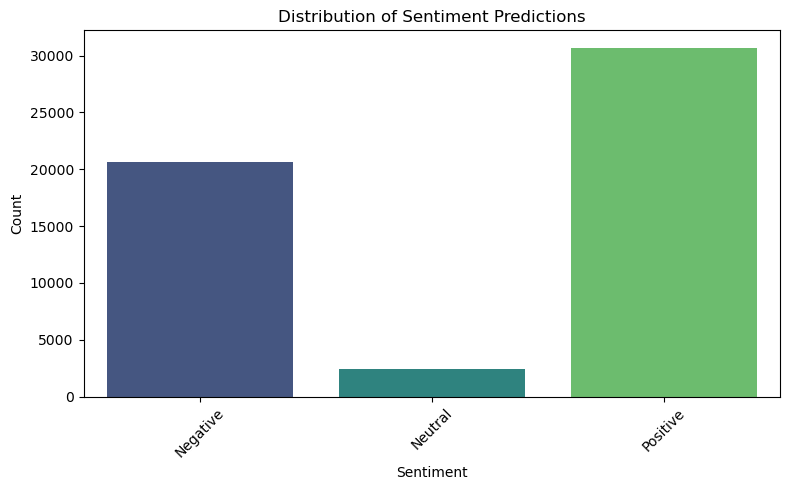

In [24]:
# Visualization of sentiment prediction distribution
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.countplot(x='sentiment_pred', data=df_pred, palette='viridis')
plt.title('Distribution of Sentiment Predictions')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [30]:
df_pred['sla_status'].value_counts()

sla_status
SLA Met          25736
Not Responded    17234
SLA Missed       10749
Name: count, dtype: int64

C:\Users\user\AppData\Local\Temp\ipykernel_4356\3348862679.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sla_status', data=df_pred, palette='viridis')


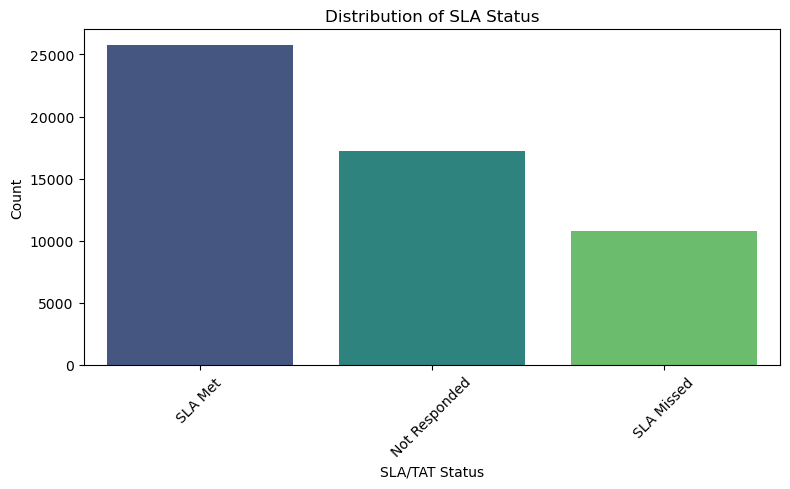

In [31]:
# Visualization of sentiment prediction distribution
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.countplot(x='sla_status', data=df_pred, palette='viridis')
plt.title('Distribution of SLA Status')
plt.xlabel('SLA/TAT Status')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


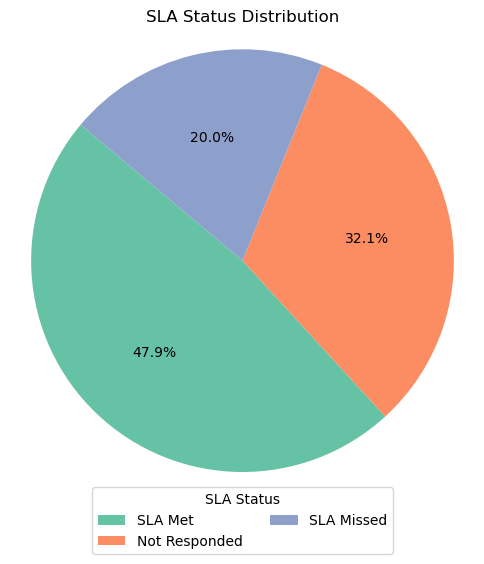

In [37]:
# Pie chart of SLA Status distribution with no labels on chart, legend below
import matplotlib.pyplot as plt
sla_counts = df_pred['sla_status'].value_counts()
fig, ax = plt.subplots(figsize=(6,6))
wedges, texts, autotexts = ax.pie(sla_counts.values, labels=None, autopct='%1.1f%%', startangle=140, colors=plt.cm.Set2.colors)
plt.title('SLA Status Distribution')
plt.axis('equal')
plt.legend(wedges, sla_counts.index, title='SLA Status', loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.show()

In [25]:
df_pred['department_pred'].value_counts()

department_pred
General              31809
Application          15186
CustomerService       3302
TransfersPayments     1048
Cards                  891
FeesCharges            436
Fraud                  367
CASA                   329
Offers                 326
Deposits                15
Investment              10
Name: count, dtype: int64

C:\Users\user\AppData\Local\Temp\ipykernel_4356\1577893614.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='department_pred', data=df_pred, palette='viridis')


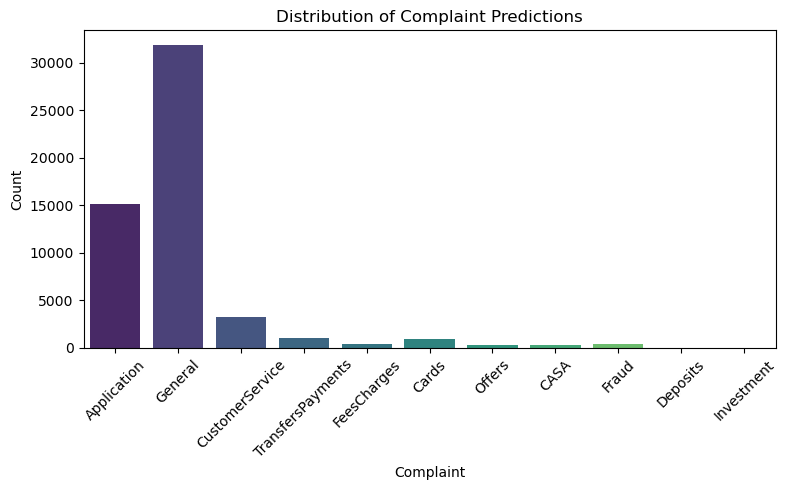

In [26]:
# Visualization of sentiment prediction distribution
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.countplot(x='department_pred', data=df_pred, palette='viridis')
plt.title('Distribution of Complaint Predictions')
plt.xlabel('Complaint')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_4356\1364557994.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='department_pred', data=df_dept, palette='viridis')


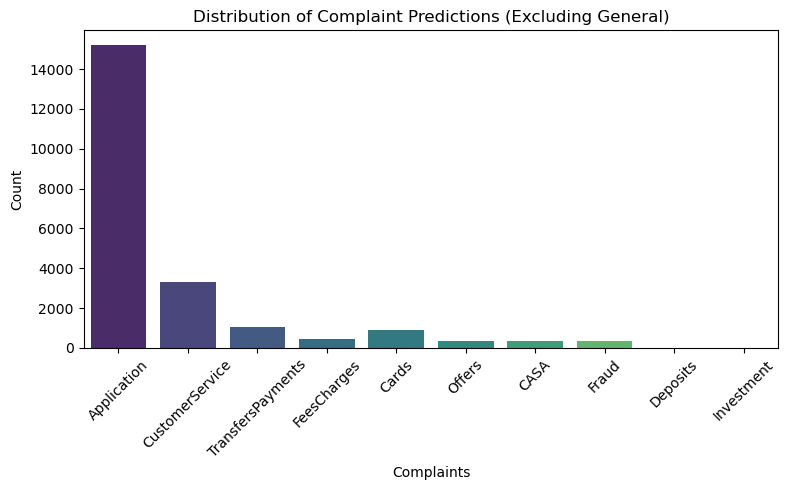

In [29]:
# Visualization of complaint predictions by department, excluding 'General'
import matplotlib.pyplot as plt
import seaborn as sns

df_dept = df_pred[df_pred['department_pred'] != 'General']

plt.figure(figsize=(8,5))
sns.countplot(x='department_pred', data=df_dept, palette='viridis')
plt.title('Distribution of Complaint Predictions (Excluding General)')
plt.xlabel('Complaints')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Randomly sample data for Department Prediction Evaluation

Select a random subset of reviews from the DataFrame containing the LLM's predictions. save it to a file for manual labeling, and then load the manually labeled data back to prepare for evaluating the LLM's performance.


In [ ]:
import numpy as np
import pandas as pd

# df has columns: reviewId, reviewContent, department_pred (your LLM label)

# (1) target sizes per predicted class — pick one plan:
plan_S = {  # 100 each, all for tiny strata
  "General":100,"Application":100,"CustomerService":100,"TransfersPayments":100,
  "Cards":100,"FeesCharges":100,"Fraud":100,"CASA":100,"Offers":100,
  "Deposits":15,"Investment":10
}

plan_M = {  # 150 each, all for tiny strata
  "General":150,"Application":150,"CustomerService":150,"TransfersPayments":150,
  "Cards":150,"FeesCharges":150,"Fraud":150,"CASA":150,"Offers":150,
  "Deposits":15,"Investment":10
}

def make_stratified_label_pool(df, target_per_class, seed=42):
    rng = np.random.default_rng(seed)
    parts = []
    for lab, tgt in target_per_class.items():
        g = df[df["department_pred"] == lab]
        k = min(tgt, len(g))
        parts.append(g.sample(n=k, random_state=rng.integers(1e9)))
    return pd.concat(parts, ignore_index=True)

sample_df = make_stratified_label_pool(df_pred, plan_S)  # or plan_M
len(sample_df)

925

In [ ]:
# Define the output directory and filename
output_dir = f"{path_prefix}scored/"
output_filename = "reviews_predicted_eng_sample.xlsx"
output_path = os.path.join(output_dir, output_filename)

# Save the DataFrame to an Excel file
sample_df.to_excel(output_path, index=False)

print(f"DataFrame saved to {output_path}")

DataFrame saved to /content/drive/MyDrive/Great Learning/DBA/Walsh-MS-QM640CapstoneProject/scored/reviews_predicted_eng_sample.xlsx


In [11]:
sample_df = pd.read_excel(f"{path_prefix}scored/reviews_predicted_eng_sample.xlsx")
print(sample_df.shape)
sample_df.head()

(925, 20)


,reviewId,reviewContent,rating,reviewedAt,replyContent,repliedAt,store,app_name,at_year,at_month,country,at_calc,at_eta_date,reply_in,reply_eta,sla_status,responded_by,language_pred,department_pred,sentiment_pred
0,ecd4e8db-8932-48de-8ad4-108ce788c04c,Great,5,2021-03-24 17:16:14,"Dear Abdallah, Thank you for your wonderful re...",2021-03-24 17:45:37,Google Play Store,Mashreq,2021,3,ae,2021-03-24 17:16:14,2021-03-28 09:16:14,0.489722,3.646262,SLA Met,NaN,en,General,Positive
1,e8fffe16-4704-4fb5-be42-c3906a001380,ADCB is the best ! Very reliable ! And Profess...,5,2024-04-17 04:49:36,Thank you very much for your feedback.\nA.M,2023-09-26 16:53:12,Google Play Store,ADCB,2024,4,us,2024-04-17 08:00:00,2024-04-17 20:00:00,0.000000,204.129722,SLA Met,A.M,en,General,Positive
2,54c91e84-0ace-4155-8ab2-1555eada69f3,Excellent,5,2023-12-04 19:53:00,"Hi, it's delightful to hear such positive word...",2023-12-05 13:25:38,Google Play Store,ADCB,2023,12,us,2023-12-04 19:53:00,2023-12-05 19:53:00,5.543889,0.269005,SLA Met,M.J,en,General,Positive
3,da2aa03f-d06b-423c-9ab2-1f762f065f1d,Excellent,5,2024-01-20 17:23:42,"Dear Abbas Alhashmi, Thank you for your Wonder...",2024-01-20 17:52:09,Google Play Store,ADIB,2024,1,us,2024-01-20 17:23:42,2024-01-23 19:23:42,0.474167,3.063576,SLA Met,M.M,en,General,Positive
4,09ff6a5c-1569-4315-bfa1-439152ec4689,Very faster I love it,5,2023-10-16 13:40:05,NaN,NaT,Google Play Store,FAB,2023,10,us,2023-10-16 13:40:05,2023-10-17 13:40:05,NaN,-1000.000000,Not Responded,NaN,en,General,Positive


## Load Sample Data after Manual labeling

In [4]:
sample_df_labeled = pd.read_excel(f"{path_prefix}scored/reviews_predicted_eng_sample_labelled.xlsx")
sample_df_labeled['department_actual'] = sample_df_labeled['department_actual'].str.strip()
print(sample_df_labeled.shape)
sample_df_labeled.head()

(925, 21)


,reviewId,reviewContent,rating,reviewedAt,replyContent,repliedAt,store,app_name,at_year,at_month,...,at_calc,at_eta_date,reply_in,reply_eta,sla_status,responded_by,language_pred,department_pred,department_actual,sentiment_pred
0,ecd4e8db-8932-48de-8ad4-108ce788c04c,Great,5,2021-03-24 17:16:14,"Dear Abdallah, Thank you for your wonderful re...",2021-03-24 17:45:37,Google Play Store,Mashreq,2021,3,...,2021-03-24 17:16:14,2021-03-28 09:16:14,0.489722,3.646262,SLA Met,NaN,en,General,General,Positive
1,e8fffe16-4704-4fb5-be42-c3906a001380,ADCB is the best ! Very reliable ! And Profess...,5,2024-04-17 04:49:36,Thank you very much for your feedback.\nA.M,2023-09-26 16:53:12,Google Play Store,ADCB,2024,4,...,2024-04-17 08:00:00,2024-04-17 20:00:00,0.000000,204.129722,SLA Met,A.M,en,General,General,Positive
2,54c91e84-0ace-4155-8ab2-1555eada69f3,Excellent,5,2023-12-04 19:53:00,"Hi, it's delightful to hear such positive word...",2023-12-05 13:25:38,Google Play Store,ADCB,2023,12,...,2023-12-04 19:53:00,2023-12-05 19:53:00,5.543889,0.269005,SLA Met,M.J,en,General,General,Positive
3,da2aa03f-d06b-423c-9ab2-1f762f065f1d,Excellent,5,2024-01-20 17:23:42,"Dear Abbas Alhashmi, Thank you for your Wonder...",2024-01-20 17:52:09,Google Play Store,ADIB,2024,1,...,2024-01-20 17:23:42,2024-01-23 19:23:42,0.474167,3.063576,SLA Met,M.M,en,General,General,Positive
4,09ff6a5c-1569-4315-bfa1-439152ec4689,Very faster I love it,5,2023-10-16 13:40:05,NaN,NaT,Google Play Store,FAB,2023,10,...,2023-10-16 13:40:05,2023-10-17 13:40:05,NaN,-1000.000000,Not Responded,NaN,en,General,General,Positive


In [5]:
import pandas as pd

# Generate a confusion matrix/contingency table
confusion_matrix = pd.crosstab(sample_df_labeled['department_actual'], sample_df_labeled['department_pred'], rownames=['Actual'], colnames=['Predicted'])

# Display the confusion matrix
print("Confusion Matrix (Actual vs. Predicted Department):")
display(confusion_matrix)

Confusion Matrix (Actual vs. Predicted Department):


Predicted,Application,CASA,Cards,CustomerService,Deposits,FeesCharges,Fraud,General,Investment,Offers,TransfersPayments
Actual,,,,,,,,,,,
Application,98,5,8,8,1,0,54,5,3,12,1
CASA,1,69,3,1,0,0,1,2,0,5,0
Cards,0,16,81,1,1,0,4,0,0,2,0
CustomerService,1,1,1,88,0,1,0,3,0,5,1
Deposits,0,0,0,0,9,0,0,0,0,0,0
FeesCharges,0,7,3,0,4,98,3,0,0,4,0
Fraud,0,0,0,1,0,0,31,0,0,0,0
General,0,0,1,0,0,0,3,90,0,9,0
Investment,0,0,0,0,0,0,0,0,6,0,0


## Evaluate with Importance Weights

In [12]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

# population counts per predicted class
N_k = df_pred["department_pred"].value_counts()
# sample counts per predicted class
n_k = sample_df["department_pred"].value_counts()
# per-item weights
w_k = (N_k / n_k).to_dict()
sample_df["weight"] = sample_df["department_pred"].map(w_k).astype(float)

y_true = sample_df_labeled["department_actual"].values
y_pred = sample_df["department_pred"].values     # evaluating current LLM predictions
w      = sample_df["weight"].values

# Overall accuracy (weighted, unbiased for the full population)
acc = accuracy_score(y_true, y_pred, sample_weight=w)

# Per-class precision/recall/F1 (weighted)
labels = sorted(df_pred["department_pred"].unique().tolist())
prec, rec, f1, support = precision_recall_fscore_support(
    y_true, y_pred, labels=labels, sample_weight=w, zero_division=0
)

# Weighted confusion matrix (unbiased)
cm = confusion_matrix(y_true, y_pred, labels=labels, sample_weight=w)

print(f"Weighted accuracy: {acc:.3f}")
for i, lab in enumerate(labels):
    print(f"{lab:18s}  Precision={prec[i]:.3f}  Recall={rec[i]:.3f}  F1-Score={f1[i]:.3f}  (weighted support={support[i]:.1f})")


Weighted accuracy: 0.915
Application         Precision=0.980  Recall=0.872  F1-Score=0.923  (weighted support=17076.4)
CASA                Precision=0.690  Recall=0.207  F1-Score=0.319  (weighted support=1094.8)
Cards               Precision=0.810  Recall=0.870  F1-Score=0.839  (weighted support=829.6)
CustomerService     Precision=0.880  Recall=0.717  F1-Score=0.790  (weighted support=4055.2)
Deposits            Precision=0.600  Recall=1.000  F1-Score=0.750  (weighted support=9.0)
FeesCharges         Precision=0.980  Recall=0.846  F1-Score=0.908  (weighted support=505.1)
Fraud               Precision=0.310  Recall=0.775  F1-Score=0.443  (weighted support=146.8)
General             Precision=0.900  Recall=0.998  F1-Score=0.947  (weighted support=28677.4)
Investment          Precision=0.600  Recall=1.000  F1-Score=0.750  (weighted support=6.0)
Offers              Precision=0.610  Recall=1.000  F1-Score=0.758  (weighted support=198.9)
TransfersPayments   Precision=0.980  Recall=0.917  F1

## Confidence Intervals

In [13]:
import numpy as np, math

def wilson_ci(k, n, z=1.96):
    p = k/n
    denom = 1 + z*z/n
    centre = p + z*z/(2*n)
    half = z*math.sqrt((p*(1-p) + z*z/(4*n))/n)
    lo = (centre - half)/denom
    hi = (centre + half)/denom
    return lo, hi

correct = (y_true == y_pred).astype(int)
k = float((w * correct).sum())
n_eff = float(w.sum())
lo, hi = wilson_ci(k, n_eff)
print(f"Overall acc with 95% CI ≈ [{lo:.3f}, {hi:.3f}]")

Overall acc with 95% CI ≈ [0.912, 0.917]


## Bootstrap

In [14]:
import numpy as np

def bootstrap_ci(y_true, y_pred, w, n_boot=1000, alpha=0.05, random_seed=42):
    rng = np.random.default_rng(random_seed)
    accs = []
    n = len(y_true)
    for _ in range(n_boot):
        idx = rng.integers(0, n, n)
        acc = np.average(y_true[idx] == y_pred[idx], weights=w[idx])
        accs.append(acc)
    lower = np.percentile(accs, 100 * alpha / 2)
    upper = np.percentile(accs, 100 * (1 - alpha / 2))
    mean_acc = np.mean(accs)
    print(f"Bootstrap accuracy mean: {mean_acc:.3f}, {100*(1-alpha):.1f}% CI: [{lower:.3f}, {upper:.3f}]")
    return mean_acc, lower, upper

# usage:
bootstrap_ci(y_true, y_pred, w)

Bootstrap accuracy mean: 0.915, 95.0% CI: [0.878, 0.950]


(0.9152770559535213, 0.8779362645407893, 0.9496411217150166)

## Randomly sample data for Sentiment Prediction Evaluation
Select a random subset of reviews from the DataFrame containing the LLM's Sentiment predictions. save it to a file for manual labeling, and then load the manually labeled data back to prepare for evaluating the LLM's performance.

In [ ]:
import numpy as np, pandas as pd

# df has: reviewId, reviewContent, sentiment_pred
target_per = {"Positive": 200, "Negative": 200, "Neutral": 200}  # Plan M

rng = np.random.default_rng(42)
parts = []
for lab, k in target_per.items():
    g = df_pred[df_pred["sentiment_pred"] == lab]
    parts.append(g.sample(n=min(k, len(g)), random_state=rng.integers(1e9)))
sample_sent = pd.concat(parts, ignore_index=True)
len(sample_sent)

600

In [ ]:
sample_sent['sentiment_pred'].value_counts()

,count
sentiment_pred,
Positive,200
Negative,200
Neutral,200


In [ ]:
# Define the output directory and filename
output_dir = f"{path_prefix}scored/"
output_filename = "reviews_sentiment_eng_sample.xlsx"
output_path = os.path.join(output_dir, output_filename)

# Save the DataFrame to an Excel file
sample_sent.to_excel(output_path, index=False)

print(f"DataFrame saved to {output_path}")

DataFrame saved to /content/drive/MyDrive/Great Learning/DBA/Walsh-MS-QM640CapstoneProject/scored/reviews_sentiment_eng_sample.xlsx


In [15]:
sample_sent = pd.read_excel(f"{path_prefix}scored/reviews_sentiment_eng_sample.xlsx")
print(sample_sent.shape)
sample_sent.head()

(600, 20)


,reviewId,reviewContent,rating,reviewedAt,replyContent,repliedAt,store,app_name,at_year,at_month,country,at_calc,at_eta_date,reply_in,reply_eta,sla_status,responded_by,language_pred,department_pred,sentiment_pred
0,9c92388c-6b31-40a3-9f26-dc88588e798c,Great,5,2023-10-06 05:13:50,Glad you like it! :)\nS.A,2023-10-06 07:57:26,Google Play Store,ADCB,2023,10,us,2023-10-06 08:00:00,2023-10-07 14:00:00,0.000000,1.251782,SLA Met,S.A,en,General,Positive
1,556008f4-9443-4787-8be9-41e4e7f15358,Amazing good to use best app I recommend every...,5,2024-04-17 06:59:52,"Hi, thank you very much for your feedback.\nS.A",2024-04-17 14:03:52,Google Play Store,ADCB,2024,4,us,2024-04-17 08:00:00,2024-04-17 20:00:00,6.064444,0.247315,SLA Met,S.A,en,Application,Positive
2,7182c293-7cf6-4c91-8a4e-4c53df22cb3e,Good,5,2025-03-02 02:09:57,Thank you for your encouraging words. N.H\n\n,2025-03-03 13:59:53,Google Play Store,ADCB,2025,3,NaN,2025-03-03 08:00:00,2025-03-03 20:00:00,5.998056,0.250081,SLA Met,N.H,en,General,Positive
3,3f5ad288-74fe-40b8-99d1-2f1e0d32f7b6,Easy to do,5,2025-02-04 22:23:16,"Hello Sannith,\nThank you for your kind words....",2025-02-05 08:14:28,Google Play Store,Mashreq,2025,2,in,2025-02-05 08:00:00,2025-02-05 20:00:00,0.241111,0.489954,SLA Met,Mashreq,en,General,Positive
4,d03e0be5-ad5c-457e-a7bf-b79485dd5697,Great 👍,5,2022-10-13 08:04:24,"Hello, so glad you are enjoying the app. Thank...",2022-10-13 10:10:53,Google Play Store,ADCB,2022,10,us,2022-10-13 08:04:24,2022-10-15 14:04:24,2.108056,2.162164,SLA Met,S.M,en,General,Positive


## Load Sample Data after Manual labelling

In [16]:
sample_sent_labeled = pd.read_excel(f"{path_prefix}scored/reviews_sentiment_eng_sample_labeled.xlsx")
sample_sent_labeled['sentiment_actual'] = sample_sent_labeled['sentiment_actual'].str.strip()
print(sample_sent_labeled.shape)
sample_sent_labeled.head()

(600, 21)


,reviewId,reviewContent,rating,reviewedAt,replyContent,repliedAt,store,app_name,at_year,at_month,...,at_calc,at_eta_date,reply_in,reply_eta,sla_status,responded_by,language_pred,department_pred,sentiment_pred,sentiment_actual
0,9c92388c-6b31-40a3-9f26-dc88588e798c,Great,5,2023-10-06 05:13:50,Glad you like it! :)\nS.A,2023-10-06 07:57:26,Google Play Store,ADCB,2023,10,...,2023-10-06 08:00:00,2023-10-07 14:00:00,0.000000,1.251782,SLA Met,S.A,en,General,Positive,Positive
1,556008f4-9443-4787-8be9-41e4e7f15358,Amazing good to use best app I recommend every...,5,2024-04-17 06:59:52,"Hi, thank you very much for your feedback.\nS.A",2024-04-17 14:03:52,Google Play Store,ADCB,2024,4,...,2024-04-17 08:00:00,2024-04-17 20:00:00,6.064444,0.247315,SLA Met,S.A,en,Application,Positive,Positive
2,7182c293-7cf6-4c91-8a4e-4c53df22cb3e,Good,5,2025-03-02 02:09:57,Thank you for your encouraging words. N.H\n\n,2025-03-03 13:59:53,Google Play Store,ADCB,2025,3,...,2025-03-03 08:00:00,2025-03-03 20:00:00,5.998056,0.250081,SLA Met,N.H,en,General,Positive,Positive
3,3f5ad288-74fe-40b8-99d1-2f1e0d32f7b6,Easy to do,5,2025-02-04 22:23:16,"Hello Sannith,\nThank you for your kind words....",2025-02-05 08:14:28,Google Play Store,Mashreq,2025,2,...,2025-02-05 08:00:00,2025-02-05 20:00:00,0.241111,0.489954,SLA Met,Mashreq,en,General,Positive,Positive
4,d03e0be5-ad5c-457e-a7bf-b79485dd5697,Great 👍,5,2022-10-13 08:04:24,"Hello, so glad you are enjoying the app. Thank...",2022-10-13 10:10:53,Google Play Store,ADCB,2022,10,...,2022-10-13 08:04:24,2022-10-15 14:04:24,2.108056,2.162164,SLA Met,S.M,en,General,Positive,Positive


In [17]:
import pandas as pd

# Generate a confusion matrix/contingency table
confusion_matrix = pd.crosstab(sample_sent_labeled['sentiment_actual'], sample_sent_labeled['sentiment_pred'], rownames=['Actual'], colnames=['Predicted'])

# Display the confusion matrix
print("Confusion Matrix (Actual vs. Predicted Sentiments):")
display(confusion_matrix)

Confusion Matrix (Actual vs. Predicted Sentiments):


Predicted,Negative,Neutral,Positive
Actual,,,
Negative,199,18,0
Neutral,1,182,2
Positive,0,0,198


## Evaluate with Importance Weights

In [18]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

N_k = df_pred["sentiment_pred"].value_counts()             # population stratum sizes
n_k = sample_sent["sentiment_pred"].value_counts()    # labeled in each stratum
w_k = (N_k / n_k).to_dict()

w      = sample_sent["sentiment_pred"].map(w_k).astype(float).values
y_true = sample_sent_labeled["sentiment_actual"].values
y_pred = sample_sent["sentiment_pred"].values  # (or a re-run model you want to compare)

# Unbiased overall accuracy for the whole corpus
acc = accuracy_score(y_true, y_pred, sample_weight=w)

# Per-class metrics (macro & per label)
labels = ["Positive","Negative","Neutral"]
prec, rec, f1, support = precision_recall_fscore_support(
    y_true, y_pred, labels=labels, sample_weight=w, zero_division=0
)

cm = confusion_matrix(y_true, y_pred, labels=labels, sample_weight=w)
print(f"Weighted accuracy: {acc:.3f}")
for i, lab in enumerate(labels):
    print(f"{lab:9s} P={prec[i]:.3f} R={rec[i]:.3f} F1={f1[i]:.3f} (w_support={support[i]:.1f})")


Weighted accuracy: 0.988
Positive  P=0.990 R=1.000 F1=0.995 (w_support=30375.2)
Negative  P=0.995 R=0.990 F1=0.992 (w_support=20743.5)
Neutral   P=0.910 R=0.842 F1=0.875 (w_support=2600.3)


## Accuracy Confidence Intervals

In [19]:
import numpy as np, math

def wilson_ci(k, n, z=1.96):
    p = k/n
    denom = 1 + z*z/n
    centre = p + z*z/(2*n)
    half = z*math.sqrt((p*(1-p) + z*z/(4*n))/n)
    lo = (centre - half)/denom
    hi = (centre + half)/denom
    return lo, hi

correct = (y_true == y_pred).astype(int)
k = float((w * correct).sum())
n_eff = float(w.sum())
lo, hi = wilson_ci(k, n_eff)
print(f"Overall acc with 95% CI ≈ [{lo:.3f}, {hi:.3f}]")


Overall acc with 95% CI ≈ [0.987, 0.989]


## Bootstrap

In [20]:
import numpy as np

def bootstrap_ci(y_true, y_pred, w, n_boot=1000, alpha=0.05, random_seed=42):
    rng = np.random.default_rng(random_seed)
    accs = []
    n = len(y_true)
    for _ in range(n_boot):
        idx = rng.integers(0, n, n)
        acc = np.average(y_true[idx] == y_pred[idx], weights=w[idx])
        accs.append(acc)
    lower = np.percentile(accs, 100 * alpha / 2)
    upper = np.percentile(accs, 100 * (1 - alpha / 2))
    mean_acc = np.mean(accs)
    print(f"Bootstrap accuracy mean: {mean_acc:.3f}, {100*(1-alpha):.1f}% CI: [{lower:.3f}, {upper:.3f}]")
    return mean_acc, lower, upper

# usage:
bootstrap_ci(y_true, y_pred, w)

Bootstrap accuracy mean: 0.988, 95.0% CI: [0.979, 0.996]


(0.9884497294042621, 0.9788183732797257, 0.9960093475097523)